# **Projet 2:  Diverse Counterfactual Explanations (DICE)**

**DICE** is a technique in explainable AI (XAI) that generates multiple alternative explanations for a model's prediction. These explanations show how different changes in input features could lead to a different (often desired) outcome. Counterfactual explanations answer the question: *What would need to change in the input features to alter the prediction to a target value (e.g., a different class or a higher probability of defaulting)?* DICE extends traditional counterfactual explanations by generating a set of **diverse** counterfactuals, each providing unique insights into how to achieve the desired outcome.

### **Key Features of DICE**:
1. **Desired Outcome**: Counterfactuals show how to achieve a specific target (e.g., avoiding credit card default).
2. **Diversity**: Counterfactuals are distinct, offering a range of possible actions.
3. **Plausibility**: Counterfactuals are realistic and feasible in the real world.

---

## **Application to the UCI Credit Card Default Dataset**

The **UCI Credit Card Default Dataset** contains information about customers' credit card usage and behavior. The goal is to predict whether a customer will default on their payment based on features such as:
- **Age**
- **Gender**
- **Education**
- **Marriage status**
- **Bill statements**
- **Previous payment history**
- **Credit limit**

In this project, we use DICE to explore how customers can modify their features to avoid defaulting on their credit card payments.



---

## **Loading and Preprocessing the Dataset**

The dataset is loaded from the UCI repository. We rename the target column, drop the unnecessary ID column, and split the dataset into features and target.

In [7]:
# Load the dataset from the URL
import pandas as pd
import numpy as np
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)  # Skip the first row (header)

# Rename the target column and drop the ID column
df.rename(columns={'default payment next month': 'target'}, inplace=True)
df = df.drop(columns=['ID'])

# Separate features and target variable
feature = df.drop(columns=['target'])
feature.replace(to_replace={np.nan: 0.0}, inplace=True)
target = df['target']

---

## **Target Distribution Visualization**

Before diving into modeling, we visualize the distribution of default vs. non-default cases.

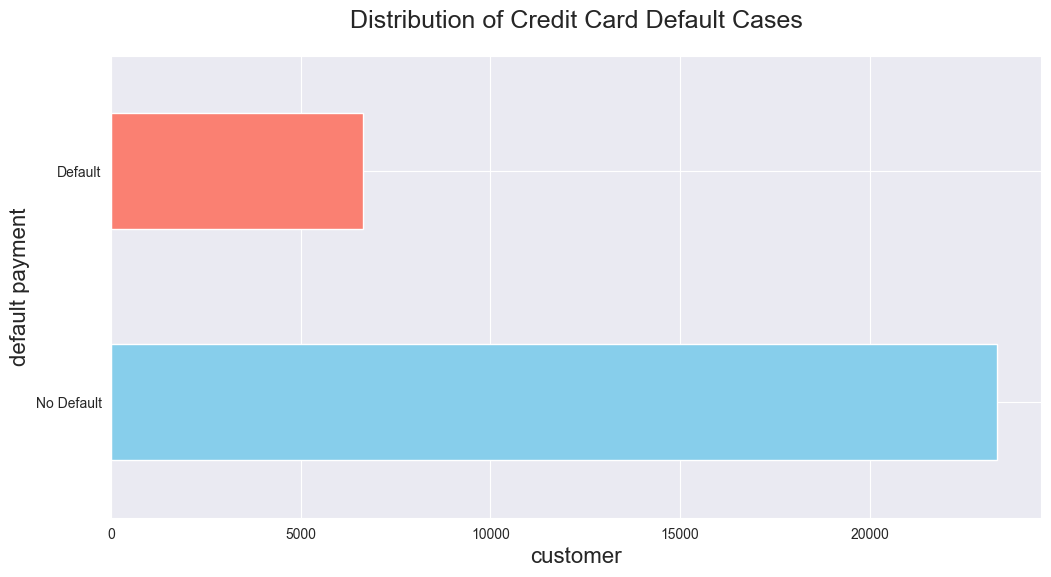

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12,6))
counter = target.value_counts()
counter.rename(index={1: "Default", 0: "No Default"}, inplace=True)
counter.plot(kind="barh", ax=ax, color=["skyblue", "salmon"])
ax.set_xlabel("customer", size=16)
ax.set_ylabel("default payment", size=16)
ax.set_title("Distribution of Credit Card Default Cases", size=18, pad=20)
plt.show()


---

## **Recoding Categorical Data**
To generate counterfactual explanations, we need categorical features in a human-readable form. We recode the numerical values for SEX, EDUCATION, and MARRIAGE into string labels.


In [9]:
# Recode SEX
feature['SEX'] = feature['SEX'].map({1: 'Male', 2: 'Female'})

# Recode EDUCATION
feature['EDUCATION'] = feature['EDUCATION'].map({
    1: 'Graduate School',
    2: 'University',
    3: 'High School',
    4: 'Others',
    5: 'Others', 
    6: 'Others',
    0: 'Others' 
})

# Recode MARRIAGE
feature['MARRIAGE'] = feature['MARRIAGE'].map({
    1: 'Married',
    2: 'Single',
    3: 'Others',
    0: 'Others' 
})


---
## **Splitting Data into Training and Test Sets**
We split the dataset into training and test sets to train our model and later evaluate its performance.

In [10]:
from sklearn.model_selection import train_test_split

# Split data with stratification on the target
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42, stratify=target)

In [11]:
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
22788,160000,Female,University,Single,33,2,2,3,2,0,...,168541,164310,162681,163005,15000,0,0,6100,12300,6100
29006,150000,Female,Graduate School,Single,34,1,-1,-1,-2,-2,...,0,0,0,0,53,0,0,0,0,0
16950,10000,Male,University,Married,50,1,2,0,0,0,...,8446,8067,8227,8400,2,1281,1134,294,305,1000
22280,220000,Female,Graduate School,Single,29,0,0,0,0,0,...,215139,218513,131660,134346,9100,9000,7887,4800,4900,6000
11346,310000,Female,Graduate School,Single,32,1,-2,-1,0,0,...,326,326,-235,-235,0,326,0,0,0,1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23479,100000,Female,University,Single,31,0,0,0,0,0,...,94421,97486,97604,97241,3309,4421,5486,3400,3541,3894
13921,120000,Female,University,Single,24,0,0,0,0,0,...,115515,113948,122127,121962,4200,4100,4100,10000,4560,0
3794,120000,Female,Graduate School,Single,24,0,0,0,0,0,...,67187,49924,33188,19826,3700,2023,2016,2000,1200,1000
27565,360000,Male,Graduate School,Married,57,1,-2,-1,-1,-1,...,860,246,-46,-46,0,860,246,0,0,0


---
## **Data Preprocessing Pipeline**

To prepare the data for model training, we build a pipeline that handles both numerical and categorical features. Numerical features are scaled using StandardScaler, while categorical features are one-hot encoded.



In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.impute import SimpleImputer

In [13]:
# Define categorical and numerical features
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
numeric_features = list(set(feature.columns) - set(categorical_features))

In [14]:
# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])


In [15]:
# Create a ColumnTransformer to apply the transformers appropriately
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  
)

---
## **Model Training and Evaluation**

We use a **Random Forest Classifier** with specified hyperparameters to predict default versus non-default outcomes. The model is integrated into a pipeline that includes the preprocessing step.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [17]:
# Set model parameters
param_grid = {
    'n_estimators': 100,
    'max_depth':  10,
    'min_samples_split': 2,
    'min_samples_leaf':1,
    'bootstrap': True
}

In [18]:

# Build the pipeline with preprocessing and classification
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**param_grid))
])

# Train the model on the training set
model = pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8155
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.35      0.45      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000



After training, the model is saved for later use:

In [19]:
import joblib
joblib.dump(model, 'xgboost_credit_default_model.pkl')

['xgboost_credit_default_model.pkl']

---
## **Confusion Matrix Visualization**

To assess the model's performance visually, we compute and plot confusion matrices for both the training and test sets.

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [21]:
# Generate predictions for both train and test sets
y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)

# Compute confusion matrices
cf_test = confusion_matrix(y_true=y_test, y_pred=y_hat_test)
cf_train = confusion_matrix(y_true=y_train, y_pred=y_hat_train)

# Define class names
names_df = ["No Default", "Default"]

# Create DataFrames for better visualization
cf_test_df = pd.DataFrame(data=cf_test, columns=names_df, index=names_df)
cf_train_df = pd.DataFrame(data=cf_train, columns=names_df, index=names_df)

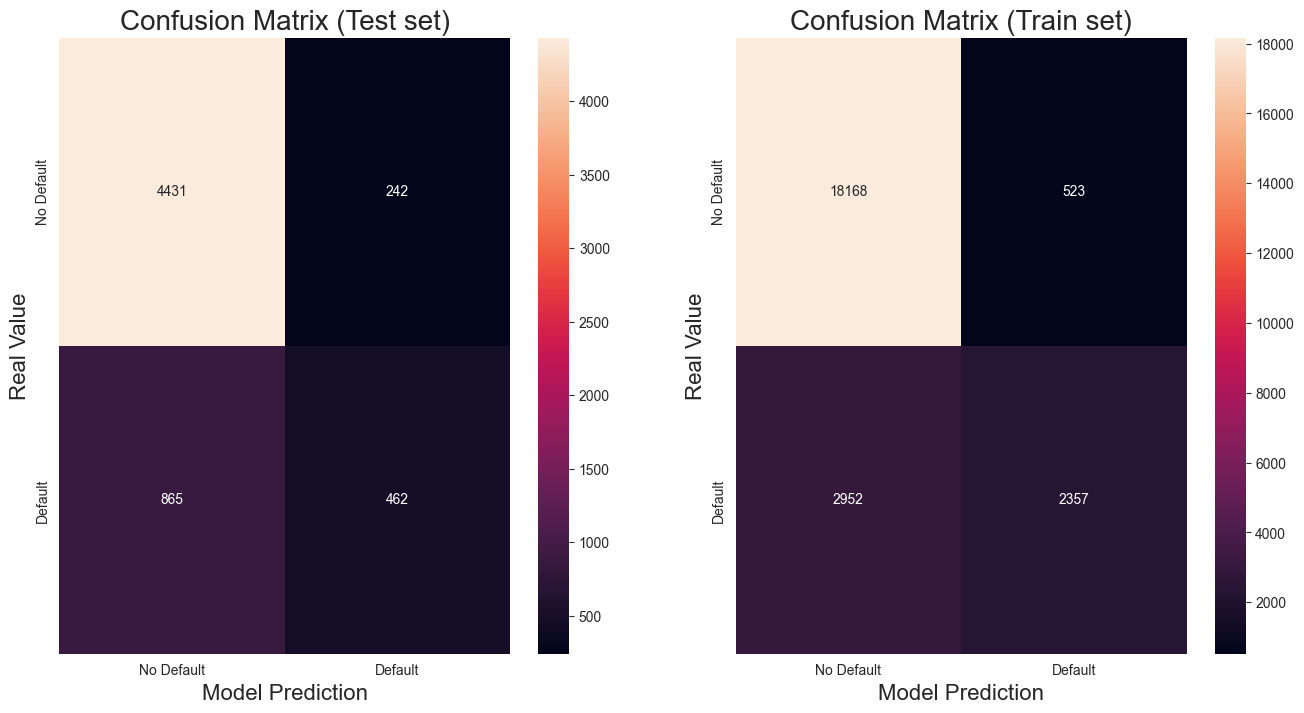

In [ ]:
# Plot the confusion matrices side by side
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

sns.heatmap(cf_test_df, fmt="d", annot=True, ax=ax[0])
ax[0].set_xlabel("Model Prediction", size=16)
ax[0].set_ylabel("Real Value", size=16)
ax[0].set_title("Confusion Matrix (Test set)", size=20)

sns.heatmap(cf_train_df, fmt="d", annot=True, ax=ax[1])
ax[1].set_xlabel("Model Prediction", size=16)
ax[1].set_ylabel("Real Value", size=16)
ax[1].set_title("Confusion Matrix (Train set)", size=20)

plt.show()

---

## **Generating Counterfactual Explanations with DiCE**

Now we use the DiCE library to generate counterfactual explanations. These explanations help understand what minimal changes in the input features could flip the model’s prediction.

### **Setting Up DiCE**

We create a DiCE data object using our complete dataset and specify the continuous features. Then we initialize a DiCE model object with our trained model.



In [25]:
import dice_ml
from dice_ml.utils import helpers
import json

ModuleNotFoundError: No module named 'dice_ml'

In [ ]:

# Combine features and target into one DataFrame for DiCE
X = pd.concat([feature, target], axis=1)

# Create DiCE data object by specifying continuous features and outcome name
data = dice_ml.Data(dataframe=X, continuous_features=list(numeric_features), outcome_name='target')

# Create DiCE model object with the trained model (using 'sklearn' backend)
dice_model = dice_ml.Model(model=model, backend='sklearn')

# Initialize the DiCE explainer with method 'random'
explainer = dice_ml.Dice(data, dice_model, method="random")

### **Selecting a Client for Analysis**

We choose an instance (customer) from the dataset to analyze. The mapping dictionary is used to interpret the target values.

In [98]:
# Select a client index to analyze
client_index = 1  # Replace with the desired client index

# Mapping for output values for easy interpretation
Card_default = {1.0: "Default", 0.0: "No Default"}

# Display the client's real status from the target data
print("------- Client Real Status ------")
real_status = Card_default[target.iloc[client_index]]
print(f"Real Status: {real_status}")

# Predict the client's status using the model
print("------- Client Predicted Status ------")
pred_class = model.predict(feature.loc[[client_index]])[0]
pred_status = Card_default[pred_class]

# Calculate and display the predicted probability
pred_prob = model.predict_proba(feature.loc[[client_index]])[0][pred_class]
pred_prob_round = round(pred_prob, 3)
print(f"Predicted Status: {pred_status}")
print(f"Probability of being classified as {pred_status}: {pred_prob_round}")

------- Client Real Status ------
Real Status: Default
------- Client Predicted Status ------
Predicted Status: No Default
Probability of being classified as No Default: 0.717


### **Generating and Visualizing Counterfactuals**

We now generate counterfactual explanations by specifying the number of counterfactuals, the desired class (opposite to the current prediction), and the features we want to allow to vary.

In [99]:
print("------- Counterfactual Explanations ------\n")
num_counterfactuals = 2  # Number of counterfactuals to generate
query_instance = feature.loc[[client_index]]  # The instance to explain

# Define the features that can be modified for counterfactuals.
features_to_vary = ["LIMIT_BAL", "MARRIAGE", "AGE", "PAY_0", "BILL_AMT1", "PAY_AMT1"]

# Generate counterfactual explanations using DiCE
counterfactual_explanations = explainer.generate_counterfactuals(
    query_instance,
    total_CFs=num_counterfactuals,
    desired_class="opposite",  # Generate counterfactuals for the opposite class
    features_to_vary=features_to_vary,
    random_seed=3434  # For reproducibility
)

# Visualize the counterfactual examples as a DataFrame
counterfactual_explanations.visualize_as_dataframe(show_only_changes=False)

------- Counterfactual Explanations ------



100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

Query instance (original outcome : 0)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,120000,Female,University,Single,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,0



Diverse Counterfactual set (new outcome: 1)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,120000,Female,University,Single,26,2,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
1,120000,Female,University,Single,26,3,2,0,0,0,...,3272,3455,3261,149628,1000,1000,1000,0,2000,1


### **Appending Predicted Probabilities to the Counterfactuals**
Finally, we add the predicted probabilities for the generated counterfactuals to the DataFrame for additional insight.

In [101]:
# Get the final counterfactual DataFrame from the first explanation list
CF_dice = counterfactual_explanations.cf_examples_list[0].final_cfs_df

# Compute predicted probabilities for each counterfactual example (excluding the target column)
pred_cf = model.predict_proba(CF_dice.drop(columns=["target"]))

# Add the predicted probabilities to the DataFrame
CF_dice[["No Default", "Default"]] = pred_cf
CF_dice  

## **Conclusion**
This notebook demonstrates how to use DICE to generate actionable insights for credit card default predictions. By identifying minimal changes in customer features, DICE helps users understand how to achieve desired outcomes (e.g., avoiding default). The approach is flexible and can be applied to other datasets and models.